# Exploratory Data Analysis
In this notebook I conduct exploratory data analysis (EDA) to gain a general understanding of the information gathered from reddit for the three subs of interest: the Magic: The Gathering, Eternal, and Hearthstone card game subreddits. I find here some trends concerning the comment frequency and most used words in regards to each of the subreddits
 - [Comment Analysis](#Comment-Analysis)
 - [Word Frequency Analysis](#Word-Frequency-Analysis)  
 
A note on data cleaning; I check for null values, but since the only fields I took from the subreddits were title and number of comments, no null values were found in the dataframe (since it would not be possible to create a post without a title, and the number of comments will always be at least a zero). When analyzing the text of the titles themselves, I apply very minimal pruning: I merely remove the non-alphabetic characters from the posts, lemmatize the words and then apply a count vectorizer.

In [1]:
# Import relevant libraries

import re
import math
import pandas as pd
import p3_functions as pf
import general_functions as lf
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
%%capture

# Check for the presence of the datafile containing the comments/titles for the three subreddits. If the file can't be read, then this runs the collection code to generate the file

try:
    df = pd.read_csv('../datasets/tcg_raw.csv')
    %store -r all_cards
except:
    %run ./p3_collection.ipynb
    df = pd.read_csv('../datasets/tcg_raw.csv')
    %store -r all_cards

In [3]:
# Create a number of static lists: Names and number of users for each subreddit as well as adding a number of tcg specific stop words for implementations of CountVectorizers

tcgs = ['Magic','Eternal','Hearthstone']
users = [406837, 17604, 1474165]
tcg_stop_words = stopwords.words('english') + ['play','player','game','tcg','card', 'cards', 'mtg', 'hearthstone', 
                                               'eternal', 'deck', 'decks', 'sub', 'gathering', 'blizzard', 'magic', 'dwd', 'wotc']

In [4]:
# Check for null values in the dataframe

lf.check_frame(df)

No null values in data set


## Comment Analysis
In examining each game's community, I am interested in learning which topics generate the most conversation - what topics are people commenting on and discussing. I examine the distribution of the number of comments per post for each of the subreddits.

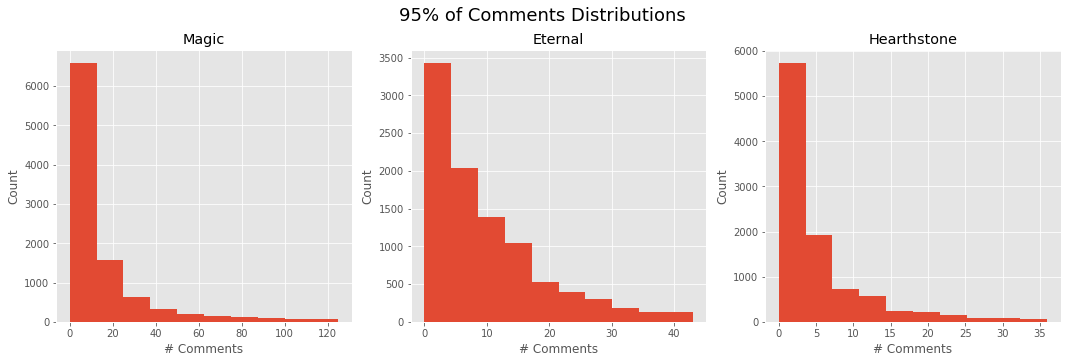

In [5]:
# Slice the dataframe by subreddit and collect the number of comments for each. 
# We omit posts with the top 5% of number of comments in order to make the histograms
# easier to visualize (the top 5% of posts extend the range of the histogram by an order of magnitude)

all_comments = []
for x in range(3):
    comments = list(df[df['sub']==x]['num_comments'])
    comments.sort()
    all_comments.append(comments[:int(len(comments)*0.95)])

lf.subplot(['hist']*3, all_comments, title_list=tcgs, xlab_list=['# Comments']*3, 
           ylab_list=['Count']*3, fig_title='95% of Comments Distributions')

As expected, most posts generate only a few comments; approximately a third of all posts have 2 or less comments attached to them, which is fairly typical behavior for reddit. While many posts are made, most users will look at the posts without commenting. Most members will only comment on posts that have some element of controversy or information that has a widespread impact on the community

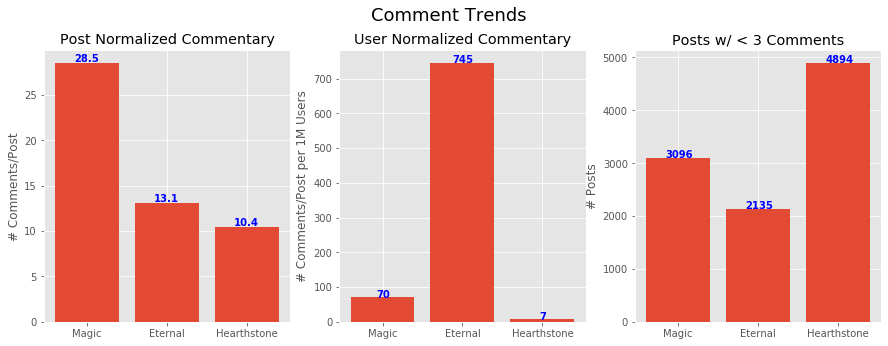

In [6]:
lf.subplot(['bar']*3, x_list=[range(3)]*3, title_list=['Post Normalized Commentary','User Normalized Commentary', 'Posts w/ < 3 Comments'], 
           ylab_list=['# Comments/Post', '# Comments/Post per 1M Users', '# Posts'], xlab_list=[tcgs]*3, 
           y_list=[[round(df[df['sub']==x]['num_comments'].sum()/len(df[df['sub']==x]),1) for x in range(3)],
                   [math.floor(df[df['sub']==x]['num_comments'].sum()/len(df[df['sub']==x])/(users[x]/1000000)) for x in range(3)],
                   [len(df[df['sub']==x][df[df['sub']==x]['num_comments']<3]) for x in range(3)]],
           fig_title='Comment Trends', h_size=15, bar_numbers=True)

If I compare the number of comments made per post (and since the number of posts gathered was nearly identical for each subreddit, this is nearly equivalent to looking at total comments) I find that the Magic community has the greatest amount of input (above, left). This is not unexpected, as it is the first, and therefore the oldest and most entrenched game. What is interesting, however, is that if I normalize to the number of users belonging to each subreddit (above, middle), then the Eternal subreddit dominates in terms of discussion. This is a good sign for the community, showing that while the numbers may be small, the community in general is more involved. This is especially telling in comparison with Hearthstone, which boasts nearly 100 times as many members, but generated less comments than Eternal. This can also be observed by examining the number of posts which generate less than 3 comments (above, right). Hearthstone has more than double the number of silent submissions than Eternal, with MTG again falling in the middle.

It is important to note here that Magic has a number of smaller, specialized subreddits (such as mtgfinance), so the data here might not be 100% accurate, but as it is from the main subreddit, it should still be fairly indicative of trends.

In [7]:
for x in range(3):
    sorted_df = df[df['sub']==x].sort_values(by='num_comments')
    print(f'\n{tcgs[x]} most commented posts:\n')
    for z, y in enumerate(zip(sorted_df['title'][:-11:-1], sorted_df['num_comments'][:-11:-1])):
        print(f'{z+1}. {y[0]}: {y[1]} comments')


Magic most commented posts:

1. [THB] Haktos the Unscarred: 1723 comments
2. Name the worst card you know: 1723 comments
3. Mark wants to know what you wanted to see in Modern Horizons, but didn't.: 1239 comments
4. New Modern product announcement ("Modern Horizons"?) -- February 28, 2PM US Pacific time: 1190 comments
5. Fetchland Reprints &amp; Chandra Signature Spellbook Official Announcement - Tolarian Community College: 1120 comments
6. Ebay's email response. Gift card + WOTC gift in near future: 1086 comments
7. [MH1]Mox Tantalite: 1015 comments
8. Double Masters VIP Edition is up for preorder - $92 per booster: 1006 comments
9. [WAR] God-Eternal Kefnet (via Cedric Philips' twitch stream cedricaphillips): 895 comments
10. Good ol Strictly BetterMtG. Just made me laugh. I love that guy.: 888 comments

Eternal most commented posts:

1. Moderator Team Statement on AlpacaLips Ban: 595 comments
2. 6/25/19 Balance Changes: 384 comments
3. 12/4 Balance Changes: 328 comments
4. Balance C

When I examine the submissions that generated the most discussion, one trend is very apparent; the posts that generate the most comments for Eternal mostly have to do with balance changes (6 general balance changes and one card-specific change). The other three topics cover finance, spoilers, and one community topic. For the other two subreddits, it is a more mixed bag, but not nearly as focused on specifically balance changes. This is purely a qualitative assessment, but could be indicative of a deficit in the community, that there is a lack of community events (such as Blizzcon) or prominent (positive) community members (such as Strictly BetterMtG) that could promote greater brand loyalty.

## Word Frequency Analysis
In addition to the amount of community input and discussion, I am also interested in determining the topics that are being raised and talked about. In order to accomplish this, I implement Natural Language Processing (NLP) to break submissions down into individual words in order to conduct analysis on the word frequency. By determining the most frequent words, I can get a grasp of general trends in posts, although due to the nuances and often ambiguous nature of human language, this is only meant to be taken as a broad strokes view.

In [8]:
# Remove numbers and special characters from each word in each submission. Uses the default WordNetLemmatize to lemmatize each word
# Creates a new column in the dataframe to hold the modified title

df['ptitle'] = [pf.parser(title) for title in df['title']]
all_cards = pf.parser(all_cards)
all_cards = list(set(all_cards.split(' ')))

In [9]:
# Instantiate two CountVectorizer objects (monograms, bigrams) using some simple parameters
# Collects the feature dataframes in a number of lists
# These CountVectorizer objects are not meant for modeling, which will be conducted at a later step

one_vec = CountVectorizer(stop_words = tcg_stop_words, min_df=10, max_df=0.95, ngram_range=(1,1))
two_vec = CountVectorizer(stop_words = 'english', min_df=10, max_df=0.95, ngram_range=(2,2))

all_features = pf.create_feature_df(df, one_vec)
all_bigrams = pf.create_feature_df(df, two_vec)

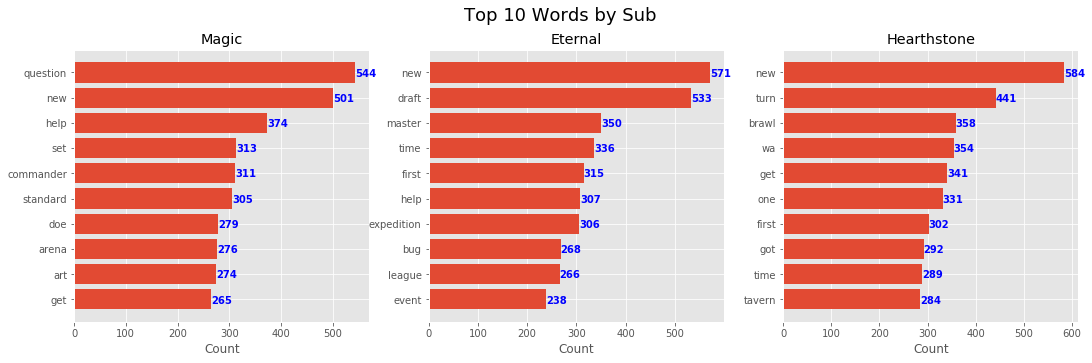

In [10]:
pf.plot_top(all_features, one_vec, 10, 'Top 10 Words by Sub');

When I examine the top words for each of the three subreddits, I find some similar trends between all three. Many of the singular top words (after stop words have been removed) can be broken down into two categories: game modes/formats, and inquisitive posts. For example, in Eternal, the words relating to game formats would be: draft, expedition, league, masters and throne, which all deal with different ways to play the game. The other words (new, help, time, first) mostly relate to players seeking help from the subreddit. This can also be seen with both the Magic and Hearthstone subs, except using terminology more specific to their games, such as modern/standard for Magic and tavern, brawl, and arena for Hearthstone.  

Things to note here are the presence of 'bug' as one of the top words in the Eternal subreddit, which is not present in the other two subs. All three games have digital platforms, yet Eternal is the only one where errors in the program is a prominent word for discussion, which could be cause for concern. The other thing to note is that the word 'new' is either the top or second word for all games, suggesting that these forums are a popular place for newer players to seek help.

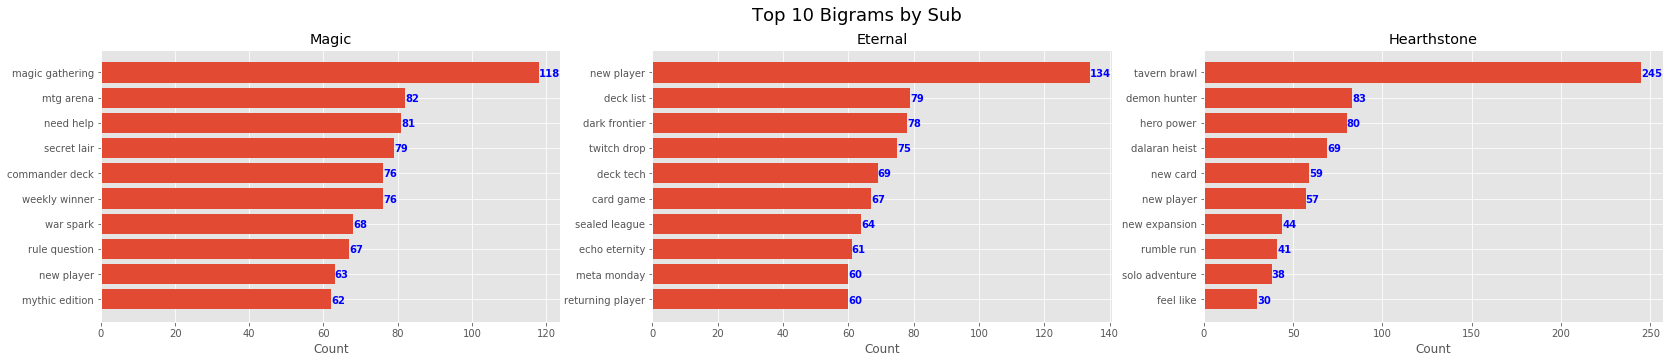

In [11]:
pf.plot_top(all_bigrams, two_vec, 10, 'Top 10 Bigrams by Sub', 28);

For bigram analysis, I use the default 'english' stop word list, as bigrams are likely to be (slightly) less affected by the presence of game specific words. Here I find similar trends among all three games. Most of the common two word combinations have to do with game specific terms or game modes. Of the bigrams not related to these things, many again have to do with solicitations for help ('new player', 'rules question', 'need help'). For Eternal, it is interesting to note that 'twitch drops' and 'farming eternal' made the list, which are related to in-game economy and card collection. These types of topics are not present in the other two subreddits, suggesting that it is of greater importance to the community.

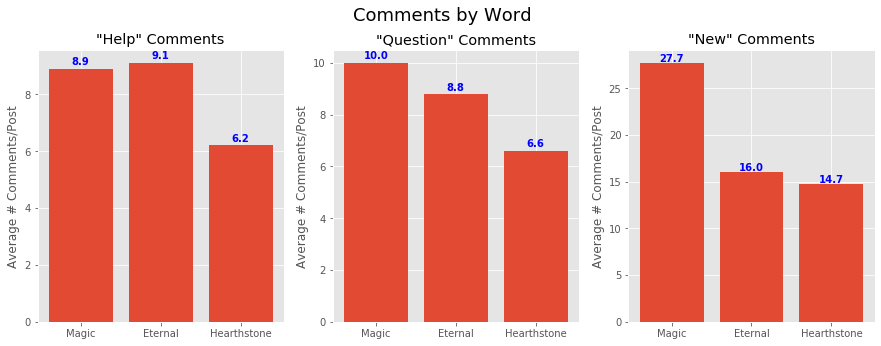

In [12]:
# Visualize the number of comments associated with posts containing the word help or question

lf.subplot(['bar']*3, x_list=[range(3)]*3, title_list=['"Help" Comments','"Question" Comments', '"New" Comments'], xlab_list=[tcgs]*3, 
           ylab_list=['Average # Comments/Post']*3, y_list=[pf.word_comments(df, all_features, x) for x in ['help','question', 'new']], 
           fig_title='Comments by Word', h_size=15, bar_numbers=True)

Lastly, I took a look at how many comments were generated for posts containing words that were indicative of users asking for help. This gives a (very rough) estimate for how "helpful" a community is. What I found is that, in general, Magic and Eternal players tended to provided more responses to these types of posts than the Hearthstone subreddit, despite the fact that again, the Hearthstone sub has many more members enrolled.

In [13]:
%%capture

# Store the parsed dataframe and card list

%store df
%store all_cards